In [1]:
import gc
import os
import sys
import math
import random
import warnings
import pickle
from pathlib import Path
from joblib import Parallel, delayed
from statsmodels.tsa.deterministic import (CalendarFourier,
                                           CalendarSeasonality,
                                           CalendarTimeTrend,
                                           DeterministicProcess)

from tqdm import tqdm
import os
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# from pandarallel import pandarallel
# pandarallel.initialize()
warnings.simplefilter("ignore")
import ctypes as ct
from datetime import timedelta

from sklearn.metrics import mean_absolute_error

import statistics as st
# import lightgbm as lgbm
import optuna.integration.lightgbm as lgbm

from scipy.stats import norm

In [2]:
sys.path.append('../../')
import src.utils as utils

## Param

In [3]:
targets_cols = ['playerId', 'target1', 'target2', 'target3', 'target4', 'date']
players_cols = ['playerId', 'primaryPositionName', 'birthCity', 'DOY', 'mlbDebutYear', 'DebutAge', 'heightInches', 'weight']
rosters_cols = ['playerId', 'teamId', 'status', 'date']
transactions_cols = ['playerId', 'transaction_flag', 'date']
scores_cols = ['playerId', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances', 'date']

feature_cols1 = ['week_day','label_playerId', 'label_primaryPositionName', 'label_teamId',
       'label_status', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances',
        "target1_mean","target1_median","target1_std","target1_min","target1_max","target1_skew","target1_kurt",
         "target2_mean","target2_median","target2_std","target2_min","target2_max","target2_skew","target2_kurt",
        "target3_mean","target3_median","target3_std","target3_min","target3_max","target3_skew","target3_kurt",
        "target4_mean","target4_median","target4_std","target4_min","target4_max","target4_skew","target4_kurt", 
        'tgt1_2_corr', 'tgt1_3_corr', 'tgt2_3_corr', 'tgt1_4_corr', 'tgt2_4_corr', 'tgt3_4_corr', 'daysSinceLastGame'] 

feature_cols2 = ['label_playerId', 'label_primaryPositionName', 'label_teamId',
       'label_status', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances',
        "target1_mean","target1_median","target1_std","target1_min","target1_max","target1_skew","target1_kurt",
         "target2_mean","target2_median","target2_std","target2_min","target2_max","target2_skew","target2_kurt",
        "target3_mean","target3_median","target3_std","target3_min","target3_max","target3_skew","target3_kurt",
        "target4_mean","target4_median","target4_std","target4_min","target4_max","target4_skew","target4_kurt", 
        'tgt1_2_corr', 'tgt1_3_corr', 'tgt2_3_corr', 'tgt1_4_corr', 'tgt2_4_corr', 'tgt3_4_corr', 'daysSinceLastGame'] 

feature_cols3 = ['week_day','label_playerId', 'label_primaryPositionName', 'label_teamId',
       'label_status', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances',
        "target1_mean","target1_median","target1_std","target1_min","target1_max","target1_skew","target1_kurt",
         "target2_mean","target2_median","target2_std","target2_min","target2_max","target2_skew","target2_kurt",
        "target3_mean","target3_median","target3_std","target3_min","target3_max","target3_skew","target3_kurt",
        "target4_mean","target4_median","target4_std","target4_min","target4_max","target4_skew","target4_kurt", 
        'tgt1_2_corr', 'tgt1_3_corr', 'tgt2_3_corr', 'tgt1_4_corr', 'tgt2_4_corr', 'tgt3_4_corr', 'daysSinceLastGame'] 

feature_cols4 = ['week_day', 'annual_day', 'month', 'label_playerId', 'label_primaryPositionName', 'label_teamId', 'label_birthCity',
                'DOY', 'mlbDebutYear', 'DebutAge', 'heightInches', 'weight',
       'label_status', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances',
        "target1_mean","target1_median","target1_std","target1_min","target1_max","target1_skew","target1_kurt",
         "target2_mean","target2_median","target2_std","target2_min","target2_max","target2_skew","target2_kurt",
        "target3_mean","target3_median","target3_std","target3_min","target3_max","target3_skew","target3_kurt",
        "target4_mean","target4_median","target4_std","target4_min","target4_max","target4_skew","target4_kurt", 
        'tgt1_2_corr', 'tgt1_3_corr', 'tgt2_3_corr', 'tgt1_4_corr', 'tgt2_4_corr', 'tgt3_4_corr', 'daysSinceLastGame'] 

In [4]:
# training lightgbm
params1 = {'objective':'mae',
           'reg_alpha': 0.14947461820098767, 
           'reg_lambda': 0.10185644384043743, 
           'n_estimators': 3633, 
           'learning_rate': 0.08046301304430488, 
           'num_leaves': 674, 
           'feature_fraction': 0.9101240539122566, 
           'bagging_fraction': 0.9884451442950513, 
           'bagging_freq': 8, 
           'min_child_samples': 51}

params2 = {'objective':'mae',
           'reg_alpha': 0.1,
           'reg_lambda': 0.1, 
           'n_estimators': 80,
           'learning_rate': 0.1,
           'random_state': 42,
           "num_leaves": 22}

params3 = {'objective':'mae',
           'reg_alpha': 0.1,
           'reg_lambda': 0.1, 
           'n_estimators': 10000,
           'learning_rate': 0.1,
           'random_state': 42,
           "num_leaves": 100}

params4 = {'objective':'mae',
           'reg_alpha': 0.016468100279441976, 
           'reg_lambda': 0.09128335764019105, 
           'n_estimators': 9868, 
           'learning_rate': 0.10528150510326864, 
           'num_leaves': 157, 
           'feature_fraction': 0.5419185713426886, 
           'bagging_fraction': 0.2637405128936662, 
           'bagging_freq': 19, 
           'min_child_samples': 71}


In [5]:
EXP_NUM = 22
NFOLDS = 5
SEED = 777

In [6]:
utils.set_seed(SEED)

## Dir

In [7]:
DATA_DIR = Path("/home/knikaido/work/MLB-Player-Digital-Engagement-Forecasting/data/")
MAIN_DATA_DIR = DATA_DIR / 'mlb-player-digital-engagement-forecasting'
TRAIN_DIR = MAIN_DATA_DIR / 'train'
OUTPUT_DIR = Path('./output/')

In [8]:
players = pd.read_csv(MAIN_DATA_DIR / 'players.csv')

rosters = pd.read_csv(TRAIN_DIR / 'rosters_train.csv')
targets = pd.read_csv(TRAIN_DIR / 'nextDayPlayerEngagement_train.csv')
scores = pd.read_csv(TRAIN_DIR / 'playerBoxScores_train.csv')
scores = scores.groupby(['playerId', 'date']).sum().reset_index()
seasons = pd.read_csv(MAIN_DATA_DIR / 'seasons.csv')

# events = pd.read_csv(TRAIN_DIR / 'events_train.csv')
# events = events.groupby(['gameDate']).sum().reset_index()


In [9]:
scores

,playerId,date,home,gamePk,teamId,jerseyNum,positionCode,battingOrder,gamesPlayedBatting,flyOuts,...,sacBuntsPitching,sacFliesPitching,saves,holds,blownSaves,assists,putOuts,errors,chances,index
0,112526,20180402,0,529469,140,40.0,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,91
1,112526,20180408,1,529546,140,40.0,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,97
2,112526,20180410,1,529565,140,40.0,1,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,99
3,112526,20180415,0,529640,140,40.0,1,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,104
4,112526,20180421,1,529718,140,40.0,1,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182945,685503,20210409,1,634478,140,35.0,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1194
182946,685503,20210414,0,634496,140,35.0,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1199
182947,685503,20210419,0,634536,140,35.0,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1204
182948,685503,20210425,0,634393,140,35.0,1,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1210


In [10]:
seasons

,seasonId,seasonStartDate,seasonEndDate,preSeasonStartDate,preSeasonEndDate,regularSeasonStartDate,regularSeasonEndDate,lastDate1stHalf,allStarDate,firstDate2ndHalf,postSeasonStartDate,postSeasonEndDate
0,2017,2017-04-02,2017-11-01,2017-02-22,2017-04-01,2017-04-02,2017-10-01,2017-07-09,2017-07-11,2017-07-14,2017-10-03,2017-11-01
1,2018,2018-03-29,2018-10-28,2018-02-21,2018-03-27,2018-03-29,2018-10-01,2018-07-15,2018-07-17,2018-07-19,2018-10-02,2018-10-28
2,2019,2019-03-20,2019-10-30,2019-02-21,2019-03-26,2019-03-20,2019-09-29,2019-07-07,2019-07-09,2019-07-11,2019-10-01,2019-10-30
3,2020,2020-07-23,2020-10-28,2020-02-21,2020-07-22,2020-07-23,2020-09-27,2020-08-25,NaN,2020-08-26,2020-09-29,2020-10-28
4,2021,2021-02-28,2021-10-31,2021-02-28,2021-03-30,2021-04-01,2021-10-03,2021-07-11,2021-07-13,2021-07-15,2021-10-04,2021-10-31


In [11]:
seasons_startend = seasons
seasons_startend['seasonStartDate'] = seasons_startend['seasonStartDate'].str.replace('-', '').astype(int)
seasons_startend['seasonEndDate'] = seasons_startend['seasonEndDate'].str.replace('-', '').astype(int)
seasons_startend = seasons_startend[['seasonStartDate', 'seasonEndDate']]

In [12]:
targets_train = targets[(targets['date'] >= 20210331)]

In [13]:
targets_train

,engagementMetricsDate,playerId,target1,target2,target3,target4,index,date
2442285,2021-04-01,502210,0.017134,3.877565,0.003982,14.986099,1185,20210331
2442286,2021-04-01,630105,0.090707,15.558301,0.014335,1.734738,1185,20210331
2442287,2021-04-01,621532,0.000353,0.288244,0.000398,0.129224,1185,20210331
2442288,2021-04-01,468504,0.008391,5.922723,0.986705,2.365196,1185,20210331
2442289,2021-04-01,657108,1.105526,10.486583,0.070877,1.585934,1185,20210331
...,...,...,...,...,...,...,...,...
2506171,2021-05-01,451661,0.000000,0.013314,0.000000,0.625925,1215,20210430
2506172,2021-05-01,519301,0.000131,0.003329,0.000000,0.216229,1215,20210430
2506173,2021-05-01,527055,0.000000,0.019971,0.000000,0.273131,1215,20210430
2506174,2021-05-01,543484,0.000131,0.056586,0.000000,1.024240,1215,20210430


In [14]:
playerId_list = targets_train['playerId'].unique()

In [15]:
def calc_corr(df):
    # 相関係数行列を作成
    corr_mat = df.corr(method='pearson')

    # 行（列）サイズを取得
    n = corr_mat.shape[0]
    corr_ary = []

    for i in range(n):
        for j in range(i):
            if i == j:
                continue
            corr_ary.append(corr_mat.iloc[i,j])

    return corr_ary

In [16]:
def calc_probs(pid,df,temp):
    to_append=[pid,'','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','']
    targets=['target1','target2','target3','target4']
    z=1
    for target in targets:
        target_prob = temp[target].tolist()
        mean = np.mean(target_prob)
        std = np.std(target_prob)
        median = st.median(target_prob)
        distribution = norm(mean, std)
        min_weight = min(target_prob)
        max_weight = max(target_prob)
        values = list(np.linspace(min_weight, max_weight))
        probabilities = [distribution.pdf(v) for v in values]
        max_value = max(probabilities)
        max_index = probabilities.index(max_value)
        to_append[z]=mean
        to_append[z+1]=median
        to_append[z+2]=std
        to_append[z+3]=min_weight
        to_append[z+4]=max_weight
        to_append[z+5]=target_prob[max_index]
        to_append[z+6]=temp[target].skew()
        to_append[z+7]=temp[target].kurt()

        z=z+8
    corr_ = calc_corr(temp[['target1', 'target2', 'target3', 'target4']])
    to_append[z:] = corr_  
    df_length = len(df)
    df.loc[df_length] = to_append
    return df
    

### CREATE DATAFRAME to store probabilities
column_names = ["playerId", "target1_mean","target1_median","target1_std","target1_min","target1_max","target1_prob","target1_skew","target1_kurt",
                "target2_mean","target2_median","target2_std","target2_min","target2_max","target2_prob","target2_skew","target2_kurt",
                "target3_mean","target3_median","target3_std","target3_min","target3_max","target3_prob","target3_skew","target3_kurt",
                "target4_mean","target4_median","target4_std","target4_min","target4_max","target4_prob","target4_skew","target4_kurt",
                'tgt1_2_corr', 'tgt1_3_corr', 'tgt2_3_corr', 'tgt1_4_corr', 'tgt2_4_corr', 'tgt3_4_corr']
player_target_probs = pd.DataFrame(columns = column_names)
    
for pid in tqdm(playerId_list):
    temp = targets_train[targets_train['playerId'] == pid]
    player_target_stats=calc_probs(pid,player_target_probs,temp)

100%|██████████| 2061/2061 [00:45<00:00, 45.10it/s]


In [17]:
player_target_stats

,playerId,target1_mean,target1_median,target1_std,target1_min,target1_max,target1_prob,target1_skew,target1_kurt,target2_mean,...,target4_max,target4_prob,target4_skew,target4_kurt,tgt1_2_corr,tgt1_3_corr,tgt2_3_corr,tgt1_4_corr,tgt2_4_corr,tgt3_4_corr
0,502210.0,0.035258,0.010162,0.098358,0.003972,0.526284,0.004923,4.499717,21.054009,0.919837,...,26.192647,1.347459,1.787924,2.122248,0.365838,0.966925,0.303303,0.591120,0.798025,0.557092
1,630105.0,1.851187,0.321727,4.662844,0.003946,25.603476,2.889937,4.520046,22.436395,8.003389,...,19.266433,0.541118,2.754461,8.490212,-0.104008,-0.050415,0.758184,0.009365,0.480758,0.460726
2,621532.0,0.147777,0.001076,0.477206,0.000128,2.460910,0.003597,4.184232,18.542939,1.090120,...,1.665259,0.062903,2.064791,5.671338,0.140293,0.202812,0.365802,0.223219,0.895560,0.207544
3,468504.0,0.046117,0.001027,0.235568,0.000115,1.335765,0.003718,5.559476,30.935286,1.579193,...,7.059931,0.936390,3.184795,9.878932,-0.016434,-0.034419,0.495791,-0.071227,0.779922,0.278867
4,657108.0,0.888194,0.043234,1.883895,0.004996,7.304291,6.176932,2.601388,5.841344,3.955265,...,4.739336,0.386319,1.349708,1.617276,0.492365,-0.135687,-0.284340,0.192405,0.608338,-0.293661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2056,606944.0,0.000016,0.000000,0.000058,0.000000,0.000303,0.000000,4.289845,19.732662,0.032395,...,1.081545,1.081545,3.559596,15.202383,0.107582,0.206886,0.432962,-0.066227,0.261404,-0.039798
2057,620982.0,0.000053,0.000000,0.000214,0.000000,0.001201,0.000000,5.205614,28.050238,0.012382,...,0.121965,0.018845,1.333308,1.375743,0.044047,NaN,NaN,0.109889,0.322029,NaN
2058,462480.0,0.000008,0.000000,0.000030,0.000000,0.000131,0.000000,3.757828,13.043766,0.003493,...,0.203910,0.123635,1.207814,1.094314,-0.023063,-0.047835,0.407347,0.059401,0.126776,0.021881
2059,667465.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.085977,...,0.350299,0.009643,2.585313,9.256597,NaN,NaN,-0.089247,NaN,0.192105,-0.012529


In [18]:
data_names=player_target_stats.columns.values.tolist()

In [19]:
players['DOY'] = pd.to_datetime(players['DOB'], format="%Y-%m-%d").dt.year
players['mlbDebutYear'] = pd.to_datetime(players['mlbDebutDate'], format="%Y-%m-%d").dt.year
players['DebutAge'] = players['mlbDebutYear'] - players['DOY']

In [20]:
# creat dataset
train = targets[targets_cols].merge(players[players_cols], on=['playerId'], how='left')
train = train.merge(rosters[rosters_cols], on=['playerId', 'date'], how='left')
train = train.merge(scores[scores_cols], on=['playerId', 'date'], how='left')
train = train.merge(player_target_stats, how='inner', left_on=["playerId"],right_on=["playerId"])


In [21]:
# label encoding
player2num = {c: i for i, c in enumerate(train['playerId'].unique())}
position2num = {c: i for i, c in enumerate(train['primaryPositionName'].unique())}
birthCityn2num = {c: i for i, c in enumerate(train['birthCity'].unique())}
teamid2num = {c: i for i, c in enumerate(train['teamId'].unique())}
status2num = {c: i for i, c in enumerate(train['status'].unique())}
train['label_playerId'] = train['playerId'].map(player2num)
train['label_primaryPositionName'] = train['primaryPositionName'].map(position2num)
train['label_birthCity'] = train['birthCity'].map(birthCityn2num)
train['label_teamId'] = train['teamId'].map(teamid2num)
train['label_status'] = train['status'].map(status2num)

In [22]:
date_ = pd.to_datetime(train['date'], format="%Y%m%d")
train['annual_day'] = (date_ - pd.to_datetime(date_.dt.year, format="%Y")) /  timedelta(days=1)
train['week_day'] = date_.dt.weekday
train['month'] = date_.dt.month

In [23]:
train['gameday'] = ~train['battingOrder'].isna()*1

In [24]:
train.sort_values(by=['playerId','date'],inplace=True,ascending=True)

In [25]:
def count_consecutive_items_n_cols(df, col_name_list, output_col):
    cum_sum_list = [
        (df[col_name] != df[col_name].shift(1)).cumsum().tolist() for col_name in col_name_list
    ]
    df[output_col] = df.groupby(
        ["_".join(map(str, x)) for x in zip(*cum_sum_list)]
    ).cumcount() + 1
    return df

In [26]:
train=count_consecutive_items_n_cols(train,['playerId','gameday'],'daysSinceLastGame')
train.loc[train['gameday']==1,'daysSinceLastGame']=0

In [27]:
train_game = train[train['gameday']==1]
train_last_game = train_game[~train_game.duplicated(subset='playerId', keep='last')][['playerId', 'date']]
train_last_game.columns = ['playerId', 'lastdate']
train_player_unique = pd.DataFrame(train['playerId'].unique(), columns=['playerId'])
train_last_game = pd.merge(train_player_unique, train_last_game, on=['playerId'], how='left' )
train_last_game = train_last_game.fillna(20171231)

In [28]:
train_last_game.sort_values('lastdate')

,playerId,lastdate
856,593590,20171231.0
1995,670462,20171231.0
2000,670764,20171231.0
1765,661269,20171231.0
1932,667674,20171231.0
...,...,...
473,542932,20210430.0
1480,641856,20210430.0
1481,641857,20210430.0
483,543037,20210430.0


In [29]:
seasons_startend

,seasonStartDate,seasonEndDate
0,20170402,20171101
1,20180329,20181028
2,20190320,20191030
3,20200723,20201028
4,20210228,20211031


In [30]:
on_season_idxes = 0
for raw in seasons_startend.iloc():
    idx_ = ((train['date'].astype(int) >= raw['seasonStartDate']) & (train['date'].astype(int) <= raw['seasonEndDate'])) * 1
    on_season_idxes += idx_
#     break

In [31]:
train = train[on_season_idxes == 1].reset_index(drop=True)

In [32]:
train

,playerId,target1,target2,target3,target4,date,primaryPositionName,birthCity,DOY,mlbDebutYear,...,label_playerId,label_primaryPositionName,label_birthCity,label_teamId,label_status,annual_day,week_day,month,gameday,daysSinceLastGame
0,112526,0.031761,2.731418,0.388556,6.349412,20180329,Pitcher,Altamira,1973,1997.0,...,969,0,588,1,3,87.0,3,3,0,88
1,112526,0.025906,4.622162,0.408017,11.508375,20180330,Pitcher,Altamira,1973,1997.0,...,969,0,588,1,3,88.0,4,3,0,89
2,112526,0.053185,4.767842,0.275408,14.600851,20180331,Pitcher,Altamira,1973,1997.0,...,969,0,588,1,3,89.0,5,3,0,90
3,112526,0.771100,63.601677,7.566316,100.000000,20180401,Pitcher,Altamira,1973,1997.0,...,969,0,588,1,3,90.0,6,4,0,91
4,112526,5.957846,22.427930,33.900803,38.857939,20180402,Pitcher,Altamira,1973,1997.0,...,969,0,588,7,0,91.0,0,4,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1234534,685503,0.044617,1.224728,0.009437,0.737463,20210426,Pitcher,Hiroshima,1992,2021.0,...,1713,0,902,7,0,115.0,0,4,0,1
1234535,685503,0.019123,1.178880,0.013161,0.790301,20210427,Pitcher,Hiroshima,1992,2021.0,...,1713,0,902,7,0,116.0,1,4,0,2
1234536,685503,0.015799,4.323489,0.002350,0.970273,20210428,Pitcher,Hiroshima,1992,2021.0,...,1713,0,902,7,0,117.0,2,4,0,3
1234537,685503,0.018770,31.946021,0.305491,5.938273,20210429,Pitcher,Hiroshima,1992,2021.0,...,1713,0,902,7,0,118.0,3,4,0,4


In [33]:
# def fit_lgbm(x_train, y_train, x_valid, y_valid, params: dict=None, verbose=100):
#     oof_pred = np.zeros(len(y_valid), dtype=np.float32)
#     model = lgbm.LGBMRegressor(**params)
#     model.fit(x_train, y_train, 
#         eval_set=[(x_valid, y_valid)],  
#         early_stopping_rounds=verbose, 
#         verbose=verbose)
#     oof_pred = model.predict(x_valid)
#     oof_pred = np.clip(oof_pred, 0, 100)
#     score = mean_absolute_error(oof_pred, y_valid)
#     print('mae:', score)
#     return oof_pred, model, score


In [34]:
train_X = train
train_y = train[['target1', 'target2', 'target3', 'target4']]
tr_idxs = []
val_idxs = []

In [35]:
# tr_idx = (train['date'].astype(int) < 20200801)
# val_idx = (train['date'].astype(int) >= 20200801) & (train['date'].astype(int) < 20200901)
# tr_idxs.append(tr_idx)
# val_idxs.append(val_idx)

# tr_idx = (train['date'].astype(int) < 20200901)
# val_idx = (train['date'].astype(int) >= 20200901) & (train['date'].astype(int) < 20201001)
# tr_idxs.append(tr_idx)
# val_idxs.append(val_idx)

# tr_idx = (train['date'].astype(int) < 20201001)
# val_idx = (train['date'].astype(int) >= 20201001) & (train['date'].astype(int) < 20201028)
# tr_idxs.append(tr_idx)
# val_idxs.append(val_idx)

# tr_idx = (train['date'].astype(int) < 20210228)
# val_idx = (train['date'].astype(int) >= 20210228) & (train['date'].astype(int) < 20210401)
# tr_idxs.append(tr_idx)
# val_idxs.append(val_idx)

tr_idx = (train['date'].astype(int) < 20210401)
val_idx = ~tr_idx
tr_idxs.append(tr_idx)
val_idxs.append(val_idx)

In [36]:
params = {'objective': 'regression',
          'metric': 'mae',
          'learning_rate': 0.01,
          'early_stopping_rounds':10,
          'random_seed':SEED} 

In [37]:

NFOLDS = 1
idx = 0
    
tr_idx = tr_idxs[idx]
val_idx = val_idxs[idx]

x_train = train_X.loc[tr_idx].reset_index(drop=True)
y_train = train_y.loc[tr_idx].reset_index(drop=True)
x_valid = train_X.loc[val_idx].reset_index(drop=True)
y_valid = train_y.loc[val_idx].reset_index(drop=True)


trains = lgbm.Dataset(x_train[feature_cols1], y_train['target1'])
valids = lgbm.Dataset(x_valid[feature_cols1], y_valid['target1'])


model1 = lgbm.train(params, trains, valid_sets=[trains, valids],
                    verbose_eval=False)


# score = (score1+score2+score3+score4) / 4
# print(f'score: {score}')





[I 2021-07-01 11:51:31,896] A new study created in memory with name: no-name-c560191a-32ba-47fa-b9e1-8e01ad4eb525
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.100072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


feature_fraction, val_score: 0.841588:  14%|#4        | 1/7 [00:27<02:44, 27.38s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.100352 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


feature_fraction, val_score: 0.841588:  29%|##8       | 2/7 [00:46<01:52, 22.54s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.096213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


feature_fraction, val_score: 0.841588:  43%|####2     | 3/7 [01:09<01:31, 22.93s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.339672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


feature_fraction, val_score: 0.841588:  57%|#####7    | 4/7 [01:29<01:04, 21.42s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.102722 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


feature_fraction, val_score: 0.841588:  71%|#######1  | 5/7 [01:50<00:43, 21.56s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.340798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


feature_fraction, val_score: 0.841588:  86%|########5 | 6/7 [02:10<00:20, 20.86s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.093739 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.841588:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.087090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.841588:   5%|5         | 1/20 [00:32<10:09, 32.09s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.103939 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.840278:  10%|#         | 2/20 [01:06<09:59, 33.30s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.087333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.840278:  15%|#5        | 3/20 [01:42<09:50, 34.75s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.074116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.840278:  20%|##        | 4/20 [02:18<09:22, 35.16s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070685 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.840278:  25%|##5       | 5/20 [02:50<08:31, 34.08s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.075871 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.840278:  30%|###       | 6/20 [03:25<08:01, 34.37s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.077037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.840278:  35%|###5      | 7/20 [03:59<07:22, 34.07s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.840278:  40%|####      | 8/20 [04:32<06:46, 33.86s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.840278:  45%|####5     | 9/20 [05:00<05:51, 31.97s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071773 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.840278:  50%|#####     | 10/20 [05:32<05:20, 32.09s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.077371 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.840278:  55%|#####5    | 11/20 [06:01<04:40, 31.14s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.840278:  60%|######    | 12/20 [06:32<04:08, 31.11s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.093677 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.839683:  65%|######5   | 13/20 [07:03<03:37, 31.01s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.078248 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.839683:  70%|#######   | 14/20 [07:29<02:56, 29.42s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.839683:  75%|#######5  | 15/20 [07:56<02:23, 28.65s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.080926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.839683:  80%|########  | 16/20 [08:35<02:07, 31.83s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.088747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.839683:  85%|########5 | 17/20 [09:03<01:32, 30.80s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.086543 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.839683:  90%|######### | 18/20 [09:33<01:00, 30.41s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.839683:  95%|#########5| 19/20 [10:06<00:31, 31.40s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.080774 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


bagging, val_score: 0.839683:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.076137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


bagging, val_score: 0.839683:  10%|#         | 1/10 [00:27<04:07, 27.54s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.109204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


bagging, val_score: 0.839683:  20%|##        | 2/10 [00:57<03:53, 29.13s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


bagging, val_score: 0.839683:  30%|###       | 3/10 [01:25<03:20, 28.69s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.087892 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


bagging, val_score: 0.839683:  40%|####      | 4/10 [01:53<02:50, 28.35s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.107019 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


bagging, val_score: 0.839683:  50%|#####     | 5/10 [02:22<02:22, 28.42s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.077499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


bagging, val_score: 0.839683:  60%|######    | 6/10 [02:53<01:57, 29.30s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.075465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


bagging, val_score: 0.839683:  70%|#######   | 7/10 [03:21<01:26, 28.82s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.077246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


bagging, val_score: 0.839683:  80%|########  | 8/10 [03:46<00:55, 27.68s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


bagging, val_score: 0.839683:  90%|######### | 9/10 [04:08<00:25, 25.90s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


feature_fraction_stage2, val_score: 0.839683:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.224475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


feature_fraction_stage2, val_score: 0.839683:  17%|#6        | 1/6 [00:22<01:53, 22.71s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.108102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


feature_fraction_stage2, val_score: 0.839683:  33%|###3      | 2/6 [00:51<01:44, 26.03s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.356989 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


feature_fraction_stage2, val_score: 0.839683:  50%|#####     | 3/6 [01:15<01:15, 25.20s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.210514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


feature_fraction_stage2, val_score: 0.839545:  67%|######6   | 4/6 [01:40<00:50, 25.07s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.075081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


feature_fraction_stage2, val_score: 0.839545:  83%|########3 | 5/6 [02:10<00:26, 26.91s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.839545:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.221397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.839545:   5%|5         | 1/20 [00:24<07:43, 24.41s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.317139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.839545:  10%|#         | 2/20 [00:46<06:50, 22.78s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.221102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.839545:  15%|#5        | 3/20 [01:11<06:45, 23.88s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.220660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.839545:  20%|##        | 4/20 [01:35<06:27, 24.21s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.223706 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.839545:  25%|##5       | 5/20 [02:00<06:04, 24.29s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.315731 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.839545:  30%|###       | 6/20 [02:24<05:40, 24.35s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.316888 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.839545:  35%|###5      | 7/20 [02:50<05:21, 24.72s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.229979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.839545:  40%|####      | 8/20 [03:12<04:46, 23.89s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.315304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.839545:  45%|####5     | 9/20 [03:37<04:25, 24.18s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.235446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.839545:  50%|#####     | 10/20 [04:00<03:57, 23.77s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.334172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.839545:  55%|#####5    | 11/20 [04:25<03:38, 24.24s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.222575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.839545:  60%|######    | 12/20 [04:50<03:16, 24.52s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.224620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.839545:  65%|######5   | 13/20 [05:15<02:52, 24.66s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.202305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.839545:  70%|#######   | 14/20 [05:40<02:28, 24.74s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.185223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.839543:  75%|#######5  | 15/20 [06:05<02:03, 24.80s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.214213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.839543:  80%|########  | 16/20 [06:26<01:34, 23.73s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.224639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.839543:  85%|########5 | 17/20 [06:48<01:09, 23.09s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.247128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.839543:  90%|######### | 18/20 [07:13<00:47, 23.76s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.223812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.839543:  95%|#########5| 19/20 [07:35<00:23, 23.11s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.222580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


min_data_in_leaf, val_score: 0.839543:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.239340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


min_data_in_leaf, val_score: 0.839543:  20%|##        | 1/5 [00:21<01:26, 21.50s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.248573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


min_data_in_leaf, val_score: 0.839543:  40%|####      | 2/5 [00:47<01:12, 24.16s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.294148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


min_data_in_leaf, val_score: 0.837773:  60%|######    | 3/5 [01:11<00:48, 24.29s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.185653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


min_data_in_leaf, val_score: 0.837773:  80%|########  | 4/5 [01:36<00:24, 24.43s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.302689 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


min_data_in_leaf, val_score: 0.837773: 100%|##########| 5/5 [02:01<00:00, 24.35s/it]


In [38]:
tr_idx = tr_idxs[idx]
val_idx = val_idxs[idx]

x_train = train_X.loc[tr_idx].reset_index(drop=True)
y_train = train_y.loc[tr_idx].reset_index(drop=True)
x_valid = train_X.loc[val_idx].reset_index(drop=True)
y_valid = train_y.loc[val_idx].reset_index(drop=True)

trains = lgbm.Dataset(x_train[feature_cols2], y_train['target1'])
valids = lgbm.Dataset(x_valid[feature_cols2], y_valid['target1'])


model2 = lgbm.train(params, trains, valid_sets=[trains, valids],
                    verbose_eval=False)

[I 2021-07-01 12:21:58,587] A new study created in memory with name: no-name-5b8a256c-0c51-41ec-ae6c-50e68282c34f
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


feature_fraction, val_score: 0.843538:  14%|#4        | 1/7 [00:25<02:33, 25.62s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.092748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


feature_fraction, val_score: 0.843538:  29%|##8       | 2/7 [00:45<01:50, 22.14s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


feature_fraction, val_score: 0.843176:  43%|####2     | 3/7 [01:11<01:35, 23.82s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.076284 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


feature_fraction, val_score: 0.843176:  57%|#####7    | 4/7 [01:31<01:07, 22.64s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.227619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


feature_fraction, val_score: 0.843176:  71%|#######1  | 5/7 [01:52<00:43, 21.73s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.075597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


feature_fraction, val_score: 0.843176:  86%|########5 | 6/7 [02:12<00:21, 21.18s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.393081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.843176:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072874 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.842643:   5%|5         | 1/20 [00:25<08:13, 25.99s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.841220:  10%|#         | 2/20 [00:58<08:54, 29.69s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.076165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.841220:  15%|#5        | 3/20 [01:32<09:00, 31.77s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.074097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.841220:  20%|##        | 4/20 [02:04<08:30, 31.91s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.076051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.841220:  25%|##5       | 5/20 [02:31<07:29, 29.96s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.075996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.841167:  30%|###       | 6/20 [03:02<07:05, 30.41s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.841167:  35%|###5      | 7/20 [03:33<06:38, 30.63s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069918 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.841167:  40%|####      | 8/20 [04:00<05:52, 29.37s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069993 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.841167:  45%|####5     | 9/20 [04:27<05:14, 28.63s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.841167:  50%|#####     | 10/20 [04:53<04:37, 27.79s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072761 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.841167:  55%|#####5    | 11/20 [05:24<04:19, 28.81s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072114 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.841167:  60%|######    | 12/20 [05:54<03:53, 29.22s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.075487 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.841167:  65%|######5   | 13/20 [06:23<03:25, 29.31s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068827 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.841167:  70%|#######   | 14/20 [06:53<02:55, 29.30s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.074671 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.841167:  75%|#######5  | 15/20 [07:23<02:27, 29.57s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.841167:  80%|########  | 16/20 [07:53<01:59, 29.78s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.074884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.841167:  85%|########5 | 17/20 [08:23<01:28, 29.66s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.074096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.841167:  90%|######### | 18/20 [08:55<01:01, 30.56s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.073968 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.841167:  95%|#########5| 19/20 [09:24<00:30, 30.08s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.073319 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


bagging, val_score: 0.841167:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


bagging, val_score: 0.841167:  10%|#         | 1/10 [00:22<03:19, 22.20s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


bagging, val_score: 0.841167:  20%|##        | 2/10 [00:47<03:10, 23.76s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


bagging, val_score: 0.841167:  30%|###       | 3/10 [01:14<02:59, 25.58s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071659 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


bagging, val_score: 0.841167:  40%|####      | 4/10 [01:32<02:14, 22.40s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


bagging, val_score: 0.841167:  50%|#####     | 5/10 [02:09<02:18, 27.61s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070626 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


bagging, val_score: 0.841167:  60%|######    | 6/10 [02:45<02:01, 30.41s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068638 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


bagging, val_score: 0.841167:  70%|#######   | 7/10 [03:09<01:25, 28.47s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.073829 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


bagging, val_score: 0.841167:  80%|########  | 8/10 [03:45<01:01, 30.78s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.073516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


bagging, val_score: 0.841167:  90%|######### | 9/10 [04:12<00:29, 29.78s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.074487 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


feature_fraction_stage2, val_score: 0.841167:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.293902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


feature_fraction_stage2, val_score: 0.841167:  17%|#6        | 1/6 [00:25<02:09, 25.98s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.073108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


feature_fraction_stage2, val_score: 0.841167:  33%|###3      | 2/6 [00:56<01:53, 28.50s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.075083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


feature_fraction_stage2, val_score: 0.840908:  50%|#####     | 3/6 [01:27<01:28, 29.63s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.220121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


feature_fraction_stage2, val_score: 0.840908:  67%|######6   | 4/6 [01:51<00:55, 27.66s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


feature_fraction_stage2, val_score: 0.840908:  83%|########3 | 5/6 [02:16<00:26, 26.53s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.840908:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.076113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.840908:   5%|5         | 1/20 [00:30<09:31, 30.08s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072788 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.840908:  10%|#         | 2/20 [00:58<08:43, 29.09s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.840908:  15%|#5        | 3/20 [01:30<08:34, 30.24s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.073720 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.840908:  20%|##        | 4/20 [01:58<07:51, 29.48s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.079224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.840908:  25%|##5       | 5/20 [02:28<07:27, 29.85s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.073479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.840908:  30%|###       | 6/20 [03:01<07:09, 30.65s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070704 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.840908:  35%|###5      | 7/20 [03:29<06:28, 29.88s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.840908:  40%|####      | 8/20 [03:59<05:58, 29.91s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.840908:  45%|####5     | 9/20 [04:26<05:19, 29.07s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.074800 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.840908:  50%|#####     | 10/20 [04:55<04:49, 28.92s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.840885:  55%|#####5    | 11/20 [05:24<04:22, 29.19s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.075333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.840885:  60%|######    | 12/20 [05:52<03:48, 28.62s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.840885:  65%|######5   | 13/20 [06:22<03:23, 29.00s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070021 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.840885:  70%|#######   | 14/20 [06:54<02:59, 29.86s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071840 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.840885:  75%|#######5  | 15/20 [07:24<02:30, 30.05s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.076196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.840885:  80%|########  | 16/20 [07:53<01:58, 29.66s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.073296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.840885:  85%|########5 | 17/20 [08:24<01:30, 30.25s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.078640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.840212:  90%|######### | 18/20 [08:56<01:01, 30.77s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.073564 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.840212:  95%|#########5| 19/20 [09:29<00:31, 31.43s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.077384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


min_data_in_leaf, val_score: 0.840212:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070581 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


min_data_in_leaf, val_score: 0.838817:  20%|##        | 1/5 [00:30<02:02, 30.52s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.077074 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


min_data_in_leaf, val_score: 0.838817:  40%|####      | 2/5 [01:02<01:34, 31.37s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


min_data_in_leaf, val_score: 0.838817:  60%|######    | 3/5 [01:32<01:01, 30.73s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.073354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


min_data_in_leaf, val_score: 0.838817:  80%|########  | 4/5 [02:03<00:31, 31.01s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.074014 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10184
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 112
[LightGBM] [Info] Start training from score 0.699385


min_data_in_leaf, val_score: 0.838817: 100%|##########| 5/5 [02:34<00:00, 30.85s/it]


In [39]:
tr_idx = tr_idxs[idx]
val_idx = val_idxs[idx]

x_train = train_X.loc[tr_idx].reset_index(drop=True)
y_train = train_y.loc[tr_idx].reset_index(drop=True)
x_valid = train_X.loc[val_idx].reset_index(drop=True)
y_valid = train_y.loc[val_idx].reset_index(drop=True)


trains = lgbm.Dataset(x_train[feature_cols3], y_train['target1'])
valids = lgbm.Dataset(x_valid[feature_cols3], y_valid['target1'])


model3 = lgbm.train(params, trains, valid_sets=[trains, valids],
                    verbose_eval=False)

[I 2021-07-01 12:54:27,407] A new study created in memory with name: no-name-8e11746e-6a94-4f62-82cc-87b28750bf98
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.078901 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


feature_fraction, val_score: 0.845576:  14%|#4        | 1/7 [00:18<01:53, 19.00s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.082593 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


feature_fraction, val_score: 0.845203:  29%|##8       | 2/7 [00:42<01:47, 21.49s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.217979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


feature_fraction, val_score: 0.843241:  43%|####2     | 3/7 [01:01<01:22, 20.61s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.083631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


feature_fraction, val_score: 0.843241:  57%|#####7    | 4/7 [01:23<01:03, 21.08s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


feature_fraction, val_score: 0.842369:  71%|#######1  | 5/7 [01:49<00:45, 22.66s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.304357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


feature_fraction, val_score: 0.842369:  86%|########5 | 6/7 [02:08<00:21, 21.50s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072704 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.841588:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.840181:   5%|5         | 1/20 [00:31<09:56, 31.40s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.840181:  10%|#         | 2/20 [01:07<10:19, 34.41s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.075758 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.840181:  15%|#5        | 3/20 [01:38<09:15, 32.69s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.840181:  20%|##        | 4/20 [02:17<09:21, 35.10s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.081653 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.840181:  25%|##5       | 5/20 [02:47<08:22, 33.49s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.840181:  30%|###       | 6/20 [03:14<07:15, 31.10s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.073083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.840181:  35%|###5      | 7/20 [03:49<07:01, 32.43s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.076788 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.840181:  40%|####      | 8/20 [04:17<06:10, 30.88s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.840181:  45%|####5     | 9/20 [04:52<05:54, 32.25s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.073499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.840181:  50%|#####     | 10/20 [05:20<05:10, 31.03s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.839588:  55%|#####5    | 11/20 [05:55<04:50, 32.31s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.078984 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.839239:  60%|######    | 12/20 [06:32<04:28, 33.56s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.075819 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.839239:  65%|######5   | 13/20 [07:08<04:01, 34.47s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070193 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.839239:  70%|#######   | 14/20 [07:44<03:28, 34.69s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071426 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.839239:  75%|#######5  | 15/20 [08:16<02:49, 33.90s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.075695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.839239:  80%|########  | 16/20 [08:48<02:13, 33.48s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.073794 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.839239:  85%|########5 | 17/20 [09:25<01:43, 34.58s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.078654 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.839239:  90%|######### | 18/20 [10:01<01:10, 35.05s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.075747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.839239:  95%|#########5| 19/20 [10:35<00:34, 34.69s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


bagging, val_score: 0.839239:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071958 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


bagging, val_score: 0.839239:  10%|#         | 1/10 [00:34<05:06, 34.05s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


bagging, val_score: 0.839239:  20%|##        | 2/10 [00:54<03:30, 26.33s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


bagging, val_score: 0.839239:  30%|###       | 3/10 [01:25<03:16, 28.03s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.079780 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


bagging, val_score: 0.839239:  40%|####      | 4/10 [01:48<02:38, 26.40s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071809 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


bagging, val_score: 0.839239:  50%|#####     | 5/10 [02:16<02:14, 26.96s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072753 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


bagging, val_score: 0.839239:  60%|######    | 6/10 [02:38<01:40, 25.14s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071836 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


bagging, val_score: 0.839239:  70%|#######   | 7/10 [03:08<01:20, 26.88s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070975 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


bagging, val_score: 0.839239:  80%|########  | 8/10 [03:44<00:59, 29.62s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


bagging, val_score: 0.839239:  90%|######### | 9/10 [04:24<00:32, 32.77s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.073162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


feature_fraction_stage2, val_score: 0.839239:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


feature_fraction_stage2, val_score: 0.839239:  17%|#6        | 1/6 [00:30<02:33, 30.68s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.342397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


feature_fraction_stage2, val_score: 0.839239:  33%|###3      | 2/6 [01:01<02:02, 30.74s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.342293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


feature_fraction_stage2, val_score: 0.839239:  50%|#####     | 3/6 [01:32<01:32, 30.70s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.076157 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


feature_fraction_stage2, val_score: 0.839239:  67%|######6   | 4/6 [02:01<01:00, 30.35s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.282806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


feature_fraction_stage2, val_score: 0.839239:  83%|########3 | 5/6 [02:32<00:30, 30.52s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072581 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.839239:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069848 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.839239:   5%|5         | 1/20 [00:33<10:37, 33.57s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.839239:  10%|#         | 2/20 [01:09<10:34, 35.24s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.839239:  15%|#5        | 3/20 [01:43<09:42, 34.29s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.839239:  20%|##        | 4/20 [02:19<09:23, 35.23s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.075475 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.839186:  25%|##5       | 5/20 [02:56<08:57, 35.86s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.080205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.839186:  30%|###       | 6/20 [03:33<08:23, 36.00s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.839186:  35%|###5      | 7/20 [04:04<07:29, 34.58s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.073141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.839186:  40%|####      | 8/20 [04:40<07:00, 35.06s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.073623 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.839186:  45%|####5     | 9/20 [05:13<06:19, 34.46s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.839186:  50%|#####     | 10/20 [05:47<05:41, 34.12s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070766 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.839186:  55%|#####5    | 11/20 [06:24<05:14, 34.97s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.839186:  60%|######    | 12/20 [07:02<04:48, 36.11s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071878 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.839186:  65%|######5   | 13/20 [07:39<04:14, 36.29s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.839186:  70%|#######   | 14/20 [08:16<03:38, 36.43s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.839186:  75%|#######5  | 15/20 [08:53<03:02, 36.56s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.075126 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.839184:  80%|########  | 16/20 [09:30<02:26, 36.63s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069751 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.839184:  85%|########5 | 17/20 [10:06<01:49, 36.62s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.074552 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.839184:  90%|######### | 18/20 [10:43<01:13, 36.68s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.839184:  95%|#########5| 19/20 [11:20<00:36, 36.76s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069991 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


min_data_in_leaf, val_score: 0.839184:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


min_data_in_leaf, val_score: 0.839184:  20%|##        | 1/5 [00:31<02:07, 31.98s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070708 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


min_data_in_leaf, val_score: 0.839184:  40%|####      | 2/5 [01:06<01:40, 33.57s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


min_data_in_leaf, val_score: 0.839184:  60%|######    | 3/5 [01:41<01:08, 34.37s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071176 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


min_data_in_leaf, val_score: 0.839184:  80%|########  | 4/5 [02:11<00:32, 32.40s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.076104 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10191
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 113
[LightGBM] [Info] Start training from score 0.699385


min_data_in_leaf, val_score: 0.839184: 100%|##########| 5/5 [02:43<00:00, 32.67s/it]


In [40]:
tr_idx = tr_idxs[idx]
val_idx = val_idxs[idx]

x_train = train_X.loc[tr_idx].reset_index(drop=True)
y_train = train_y.loc[tr_idx].reset_index(drop=True)
x_valid = train_X.loc[val_idx].reset_index(drop=True)
y_valid = train_y.loc[val_idx].reset_index(drop=True)


trains = lgbm.Dataset(x_train[feature_cols4], y_train['target1'])
valids = lgbm.Dataset(x_valid[feature_cols4], y_valid['target1'])


model4 = lgbm.train(params, trains, valid_sets=[trains, valids],
                    verbose_eval=False)

[I 2021-07-01 13:31:03,446] A new study created in memory with name: no-name-e635b12b-b3ed-47e0-8e23-d53538536a8a
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.079236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


feature_fraction, val_score: 0.832514:  14%|#4        | 1/7 [00:17<01:43, 17.21s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.304620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


feature_fraction, val_score: 0.831528:  29%|##8       | 2/7 [00:33<01:22, 16.41s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.234608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


feature_fraction, val_score: 0.831528:  43%|####2     | 3/7 [00:49<01:04, 16.23s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.073627 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


feature_fraction, val_score: 0.828988:  57%|#####7    | 4/7 [01:10<00:54, 18.24s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.075730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


feature_fraction, val_score: 0.826222:  71%|#######1  | 5/7 [01:30<00:37, 18.91s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.082461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


feature_fraction, val_score: 0.826222:  86%|########5 | 6/7 [01:47<00:18, 18.18s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.079910 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.826222:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.822830:   5%|5         | 1/20 [00:21<06:50, 21.62s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.820819:  10%|#         | 2/20 [00:52<08:12, 27.35s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.820819:  15%|#5        | 3/20 [01:20<07:46, 27.42s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.820819:  20%|##        | 4/20 [01:42<06:43, 25.22s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068925 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.820010:  25%|##5       | 5/20 [02:11<06:39, 26.62s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.820010:  30%|###       | 6/20 [02:31<05:43, 24.56s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.820010:  35%|###5      | 7/20 [02:53<05:07, 23.68s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.820010:  40%|####      | 8/20 [03:20<04:56, 24.70s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.073013 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.820010:  45%|####5     | 9/20 [03:43<04:25, 24.17s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072145 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.820010:  50%|#####     | 10/20 [04:12<04:17, 25.71s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067601 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.819976:  55%|#####5    | 11/20 [04:38<03:51, 25.74s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071727 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.819976:  60%|######    | 12/20 [05:04<03:25, 25.72s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070214 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.819976:  65%|######5   | 13/20 [05:29<02:58, 25.50s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070786 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.819976:  70%|#######   | 14/20 [05:53<02:31, 25.19s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.077774 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.819976:  75%|#######5  | 15/20 [06:21<02:10, 26.02s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.079896 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.819064:  80%|########  | 16/20 [06:53<01:51, 27.75s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.074372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.819064:  85%|########5 | 17/20 [07:24<01:25, 28.62s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.819064:  90%|######### | 18/20 [07:49<00:55, 27.57s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


num_leaves, val_score: 0.819064:  95%|#########5| 19/20 [08:13<00:26, 26.45s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.078261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


bagging, val_score: 0.819064:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071698 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


bagging, val_score: 0.819064:  10%|#         | 1/10 [00:28<04:16, 28.49s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069539 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


bagging, val_score: 0.819064:  20%|##        | 2/10 [00:52<03:26, 25.79s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.073154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


bagging, val_score: 0.819064:  30%|###       | 3/10 [01:31<03:42, 31.80s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.074450 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


bagging, val_score: 0.819064:  40%|####      | 4/10 [01:56<02:54, 29.13s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


bagging, val_score: 0.819064:  50%|#####     | 5/10 [02:25<02:25, 29.20s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


bagging, val_score: 0.819064:  60%|######    | 6/10 [03:01<02:06, 31.52s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


bagging, val_score: 0.819064:  70%|#######   | 7/10 [03:26<01:28, 29.43s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


bagging, val_score: 0.819064:  80%|########  | 8/10 [03:48<00:53, 26.87s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071983 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


bagging, val_score: 0.819064:  90%|######### | 9/10 [04:21<00:28, 28.85s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.076968 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


feature_fraction_stage2, val_score: 0.819064:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072700 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


feature_fraction_stage2, val_score: 0.819056:  33%|###3      | 1/3 [00:34<01:08, 34.12s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070999 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


feature_fraction_stage2, val_score: 0.819056:  67%|######6   | 2/3 [01:05<00:32, 32.40s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.819056:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.819056:   5%|5         | 1/20 [00:34<10:55, 34.50s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.819031:  10%|#         | 2/20 [01:09<10:21, 34.55s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.076901 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.819031:  15%|#5        | 3/20 [01:43<09:46, 34.48s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072956 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.819031:  20%|##        | 4/20 [02:18<09:15, 34.70s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.074416 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.819031:  25%|##5       | 5/20 [02:53<08:41, 34.75s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.819031:  30%|###       | 6/20 [03:28<08:06, 34.76s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072041 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.819031:  35%|###5      | 7/20 [04:01<07:26, 34.32s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.080842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.819031:  40%|####      | 8/20 [04:34<06:48, 34.00s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070846 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.819031:  45%|####5     | 9/20 [05:09<06:16, 34.19s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.079681 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.819031:  50%|#####     | 10/20 [05:43<05:40, 34.05s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.819031:  55%|#####5    | 11/20 [06:13<04:57, 33.00s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068790 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.819031:  60%|######    | 12/20 [06:48<04:28, 33.59s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.819031:  65%|######5   | 13/20 [07:17<03:45, 32.22s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070761 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.819031:  70%|#######   | 14/20 [07:50<03:14, 32.48s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.819031:  75%|#######5  | 15/20 [08:21<02:39, 31.98s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.819023:  80%|########  | 16/20 [08:56<02:11, 32.86s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.078733 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.819023:  85%|########5 | 17/20 [09:31<01:40, 33.39s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.819023:  90%|######### | 18/20 [10:03<01:06, 33.06s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072832 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


regularization_factors, val_score: 0.819023:  95%|#########5| 19/20 [10:36<00:33, 33.14s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.075336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


min_data_in_leaf, val_score: 0.819023:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.073034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


min_data_in_leaf, val_score: 0.819023:  20%|##        | 1/5 [00:31<02:06, 31.59s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.073590 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


min_data_in_leaf, val_score: 0.819023:  40%|####      | 2/5 [01:01<01:31, 30.56s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


min_data_in_leaf, val_score: 0.817006:  60%|######    | 3/5 [01:37<01:06, 33.12s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


min_data_in_leaf, val_score: 0.817006:  80%|########  | 4/5 [02:06<00:31, 31.51s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10899
[LightGBM] [Info] Number of data points in the train set: 1172709, number of used features: 121
[LightGBM] [Info] Start training from score 0.699385


min_data_in_leaf, val_score: 0.817006: 100%|##########| 5/5 [02:35<00:00, 31.19s/it]


In [41]:
model1.params

{'objective': 'regression',
 'metric': 'l1',
 'learning_rate': 0.01,
 'random_seed': 777,
 'feature_pre_filter': False,
 'lambda_l1': 7.635951631226586e-07,
 'lambda_l2': 1.3545756002061381e-08,
 'num_leaves': 64,
 'feature_fraction': 0.516,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 100,
 'num_iterations': 1000,
 'early_stopping_round': 10}

In [42]:
model2.params

{'objective': 'regression',
 'metric': 'l1',
 'learning_rate': 0.01,
 'random_seed': 777,
 'feature_pre_filter': False,
 'lambda_l1': 9.507051735075546e-06,
 'lambda_l2': 1.7992356814795836,
 'num_leaves': 89,
 'feature_fraction': 0.516,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 100,
 'num_iterations': 1000,
 'early_stopping_round': 10}

In [43]:
model3.params

{'objective': 'regression',
 'metric': 'l1',
 'learning_rate': 0.01,
 'random_seed': 777,
 'feature_pre_filter': False,
 'lambda_l1': 8.481151951951655e-08,
 'lambda_l2': 1.1181371584967872e-08,
 'num_leaves': 152,
 'feature_fraction': 0.5,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 20,
 'num_iterations': 1000,
 'early_stopping_round': 10}

In [44]:
model4.params

{'objective': 'regression',
 'metric': 'l1',
 'learning_rate': 0.01,
 'random_seed': 777,
 'feature_pre_filter': False,
 'lambda_l1': 1.3522116780407148e-07,
 'lambda_l2': 6.7666887821856935e-06,
 'num_leaves': 227,
 'feature_fraction': 0.48000000000000004,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 100,
 'num_iterations': 1000,
 'early_stopping_round': 10}

In [92]:
model1.predict(x_valid[feature_cols1])

array([0.6254922 , 0.6254922 , 0.6254922 , ..., 0.136638  , 0.35353022,
       0.1115049 ])

In [36]:
oof_indexes = []
for i in range(NFOLDS):
    oof_indexes.extend(val_idxs[i][val_idxs[i]==True].index.to_list())

In [37]:
y_valids[val_idx, :]
mae = mean_absolute_error(y_valids[oof_indexes, :], oof[oof_indexes, :])
print("mae:", mae)

mae: 1.0068916599762827


In [38]:
oof_df = train[targets_cols]
oof_df.iloc[oof_indexes, 1:5] = oof[oof_indexes, :]

In [39]:
oof_df.iloc[oof_indexes].to_csv(OUTPUT_DIR / f'oof{EXP_NUM}.csv')

In [40]:
oof_df.to_csv(OUTPUT_DIR / f'oof{EXP_NUM}.csv', index=False)

In [41]:
models = np.array([model1s, model2s, model3s, model4s])
with open(OUTPUT_DIR / f"models{EXP_NUM}.pickle", mode="wb") as f:
    pickle.dump(models, f)

In [42]:
weights = [0.05, 0.1, 0.15, 0.2, 0.5]

In [43]:
pred1s = 0
pred2s = 0
pred3s = 0
pred4s = 0
for i in range(NFOLDS):
    pred1 = models[0][i].predict(x_valid[feature_cols1])
    pred2 = models[1][i].predict(x_valid[feature_cols2])
    pred3 = models[2][i].predict(x_valid[feature_cols3])
    pred4 = models[3][i].predict(x_valid[feature_cols4])
    oof_valid_april = np.clip(np.array([pred1, pred2, pred3, pred4]).T, 0, 100)
    mae = mean_absolute_error(y_valid, oof_valid_april)
    print("mae:", mae)
    pred1s += pred1 * weights[i]
    pred2s += pred2 * weights[i]
    pred3s += pred3 * weights[i]
    pred4s += pred4 * weights[i]

mae: 0.9243639988545487
mae: 0.9280874388198368
mae: 0.9461138707647198
mae: 0.9205080119615825
mae: 0.9206798501283971


In [59]:
oof_valid_april = np.clip(np.array([pred1s, pred2s, pred3s, pred4s]).T, 0, 100)

In [61]:
# oof_valid_april = np.where(oof_valid_april < 0.1, 0, oof_valid_april)

In [62]:
mae = mean_absolute_error(y_valid, oof_valid_april)
print("mae:", mae)

mae: 0.9177646897044414


In [44]:
0.9165205542502022
0.9163249956481581

0.9163249956481581

## EDA pred

In [63]:
importance = pd.DataFrame(model1.feature_importances_, index=feature_cols1, columns=['importance'])
importance = importance.sort_values('importance', ascending=False)
importance.iloc[30:30].index

Index([], dtype='object')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

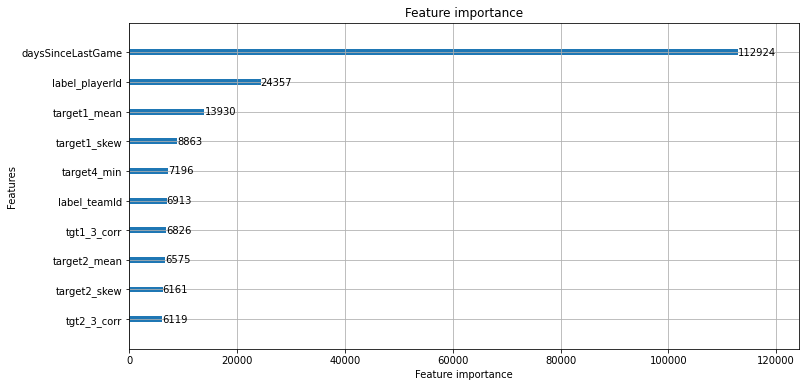

In [47]:
lgbm.plot_importance(model1, figsize=(12, 6), max_num_features=10)

In [48]:
importance = pd.DataFrame(model2.feature_importances_, index=feature_cols2, columns=['importance'])
importance = importance.sort_values('importance', ascending=False)
importance.iloc[:30].index

Index(['daysSinceLastGame', 'target4_min', 'label_status', 'label_teamId',
       'target4_median', 'target2_mean', 'target2_median', 'label_playerId',
       'target2_min', 'target2_max', 'label_primaryPositionName',
       'target2_std', 'target2_skew', 'tgt1_3_corr', 'tgt1_2_corr',
       'tgt2_4_corr', 'target3_min', 'tgt1_4_corr', 'target4_std',
       'target4_skew', 'target4_mean', 'totalBases', 'target1_min',
       'target3_median', 'target4_max', 'plateAppearances', 'target1_mean',
       'battingOrder', 'target1_std', 'tgt2_3_corr'],
      dtype='object')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

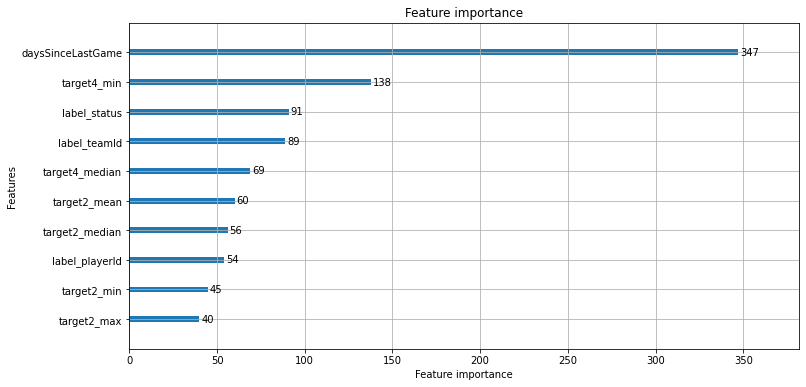

In [49]:
lgbm.plot_importance(model2, figsize=(12, 6), max_num_features=10)

In [50]:
importance = pd.DataFrame(model3.feature_importances_, index=feature_cols3, columns=['importance'])
importance = importance.sort_values('importance', ascending=False)
importance.iloc[:30].index

Index(['daysSinceLastGame', 'label_playerId', 'label_teamId', 'tgt1_3_corr',
       'target4_min', 'tgt3_4_corr', 'tgt1_2_corr', 'tgt2_4_corr',
       'target4_mean', 'target2_min', 'target4_median', 'target1_skew',
       'target1_mean', 'target2_mean', 'tgt2_3_corr', 'target2_skew',
       'tgt1_4_corr', 'target2_median', 'target4_skew', 'target2_std',
       'label_primaryPositionName', 'target3_skew', 'target3_mean',
       'target2_max', 'target3_median', 'target4_std', 'target3_std',
       'label_status', 'target4_kurt', 'target1_median'],
      dtype='object')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

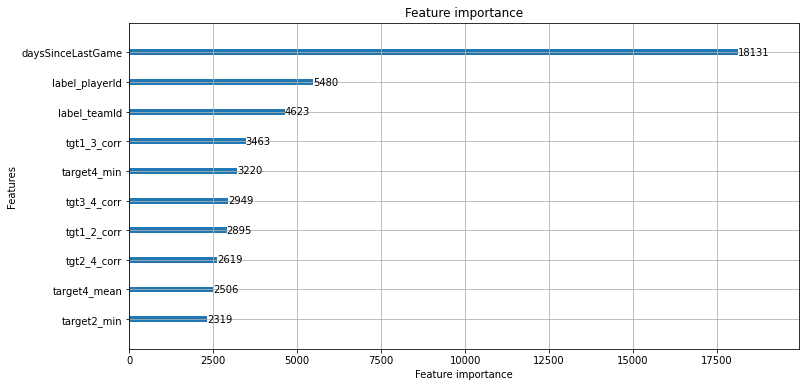

In [51]:
lgbm.plot_importance(model3, figsize=(12, 6), max_num_features=10)

In [52]:
importance = pd.DataFrame(model4.feature_importances_, index=feature_cols4, columns=['importance'])
importance = importance.sort_values('importance', ascending=False)
importance.iloc[:30].index

Index(['annual_day', 'daysSinceLastGame', 'week_day', 'target4_min',
       'label_teamId', 'month', 'target4_mean', 'target4_median',
       'label_playerId', 'tgt1_2_corr', 'mlbDebutYear', 'tgt1_3_corr',
       'tgt2_3_corr', 'target2_median', 'label_birthCity', 'tgt3_4_corr',
       'weight', 'tgt1_4_corr', 'tgt2_4_corr', 'DOY', 'target4_skew',
       'target2_skew', 'target2_min', 'target3_skew', 'target2_mean',
       'target4_std', 'target4_kurt', 'target2_std', 'target1_skew',
       'target2_kurt'],
      dtype='object')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

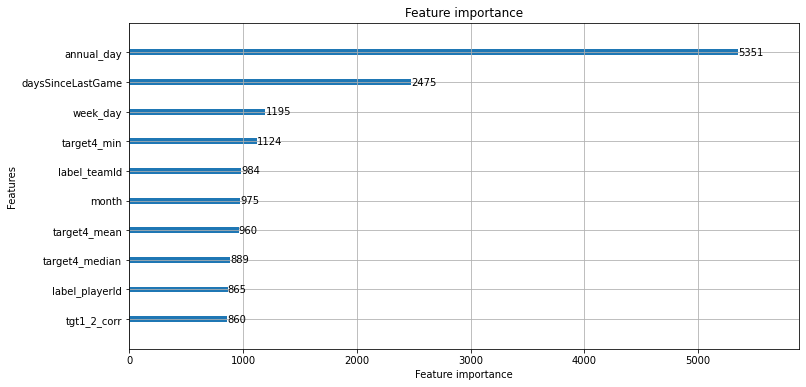

In [53]:
lgbm.plot_importance(model4, figsize=(12, 6), max_num_features=10)

## テストで取ってこれる一行はこんな感じ

In [33]:
example_sample_submission = pd.read_csv(MAIN_DATA_DIR / "example_sample_submission.csv")
example_test = pd.read_csv(MAIN_DATA_DIR / "example_test.csv")
test_df = example_test.set_index('date').iloc[:1]
sample_prediction_df = example_sample_submission[example_sample_submission['date']==test_df.index[0]].set_index('date')

In [34]:
players_cols = ['playerId', 'primaryPositionName', 'birthCity', 'DOY', 'mlbDebutYear', 'DebutAge', 'heightInches', 'weight']
rosters_cols = ['playerId', 'teamId', 'status']
scores_cols = ['playerId', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances']

null = np.nan
true = True
false = False

# env = mlb.make_env() # initialize the environment
# iter_test = env.iter_test() # iterator which loops over each date in test set

# for (test_df, sample_prediction_df) in iter_test: # make predictions here
    
sample_prediction_df = sample_prediction_df.reset_index(drop=True)

# creat dataset
sample_prediction_df['playerId'] = sample_prediction_df['date_playerId']\
                                    .map(lambda x: int(x.split('_')[1]))
# Dealing with missing values
if test_df['rosters'].iloc[0] == test_df['rosters'].iloc[0]:
    test_rosters = pd.DataFrame(eval(test_df['rosters'].iloc[0]))
else:
    test_rosters = pd.DataFrame({'playerId': sample_prediction_df['playerId']})
    for col in rosters.columns:
        if col == 'playerId': continue
        test_rosters[col] = np.nan

if test_df['playerBoxScores'].iloc[0] == test_df['playerBoxScores'].iloc[0]:
    test_scores = pd.DataFrame(eval(test_df['playerBoxScores'].iloc[0]))
else:
    test_scores = pd.DataFrame({'playerId': sample_prediction_df['playerId']})
    for col in scores.columns:
        if col == 'playerId': continue
        test_scores[col] = np.nan
test_scores = test_scores.groupby('playerId').sum().reset_index()
test = sample_prediction_df[['playerId']].copy()
test = test.merge(players[players_cols], on='playerId', how='left')
test = test.merge(test_rosters[rosters_cols], on='playerId', how='left')
test = test.merge(test_scores[scores_cols], on='playerId', how='left')
test = test.merge(player_target_stats, how='inner', left_on=["playerId"],right_on=["playerId"])


test['label_playerId'] = test['playerId'].map(player2num)
test['label_primaryPositionName'] = test['primaryPositionName'].map(position2num)
test['label_teamId'] = test['teamId'].map(teamid2num)
test['label_status'] = test['status'].map(status2num)
test['label_birthCity'] = test['birthCity'].map(birthCityn2num)

date_ = pd.to_datetime(test_df.index[0], format="%Y%m%d")
test['annual_day'] = (date_ - pd.to_datetime(date_.year, format="%Y")) /  timedelta(days=1)
test['week_day'] = date_.weekday()
test['month'] = date_.month


test_X = test

In [35]:
test_X['gameday'] = ~test_X['battingOrder'].isna()*1
test_X['date'] = test_df.index[0]
test_X = pd.merge(test_X, train_last_game, on=['playerId'], how='left')
test_X['daysSinceLastGame'] = (pd.to_datetime(test_X['date'], format="%Y%m%d") - pd.to_datetime(test_X['lastdate'], format="%Y%m%d")).dt.days
test_X.loc[test_X['gameday']==1,'daysSinceLastGame']=0

In [59]:
train_last_game = pd.merge(train_last_game, test_X[test_X['gameday']==1][['playerId','date']], on=['playerId'], how='left')
train_last_game['lastdate'].update(train_last_game['date'])
train_last_game = train_last_game[['playerId', 'lastdate']]
train_last_game

,playerId,lastdate
0,112526,20180922.0
1,134181,20180930.0
2,279571,20180930.0
3,282332,20191017.0
4,400085,20190321.0
...,...,...
2056,681911,20210426.0
2057,683232,20210426.0
2058,683734,20210426.0
2059,685493,20200927.0


In [54]:
# predict
pred1 = model1.predict(test_X[feature_cols1])
pred2 = model2.predict(test_X[feature_cols2])
pred3 = model3.predict(test_X[feature_cols3])
pred4 = model4.predict(test_X[feature_cols4])

# merge submission
sample_prediction_df['target1'] = np.clip(pred1, 0, 100)
sample_prediction_df['target2'] = np.clip(pred2, 0, 100)
sample_prediction_df['target3'] = np.clip(pred3, 0, 100)
sample_prediction_df['target4'] = np.clip(pred4, 0, 100)
sample_prediction_df = sample_prediction_df.fillna(0.)

del sample_prediction_df['playerId']

In [55]:
sample_prediction_df

,date_playerId,target1,target2,target3,target4
0,20210427_656669,4.523566,7.302453,2.559227e-01,2.723813
1,20210427_543475,0.147992,3.124557,2.008687e-01,1.193542
2,20210427_592866,0.006262,1.240768,1.289277e-02,1.045266
3,20210427_452678,0.028216,3.628774,4.949686e-02,1.776316
4,20210427_570257,0.008472,1.085709,1.132856e-02,0.437531
...,...,...,...,...,...
1182,20210427_593590,0.000010,0.013661,1.073450e-18,0.000000
1183,20210427_642180,0.002000,1.000161,3.896596e-03,0.397934
1184,20210427_663399,0.000242,0.336076,1.736459e-03,0.087545
1185,20210427_664199,0.000847,0.919104,5.898664e-03,0.507688
